# Bayesian model selection and linear regression

This notebook uses [Bayesian selection for linear regression with basis functions](https://arxiv.org/abs/1512.04823) in order to (partially) answer [question #2231975](https://math.stackexchange.com/questions/2231975/interpolating-a-given-data-by-a-simple-function/2232010#2232010) in Math StackExchange. The necessary code can be found in [bitbucket](https://bitbucket.org/mdbenito/modelselection).

The idea is to use a fixed set of simple functions to interpolate a given (small) dataset. Non-parametric regression will yield almost perfect results but it seemed not to be an option for the OP, so this is one possibility.

We begin with the usual boilerplate importing the necessary modules. Note the manipulation of the imports path in order to access the code in the local repository.

In [1]:
import sys
sys.path.append("../src/")
from Hypotheses import *
from ModelSelection import LinearRegression
from Plots import updateMAPFitPlot, updateProbabilitiesPlot
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as pl
%matplotlib notebook

We now load data and normalize it to have zero mean and variance 1. This is required to avoid numerical issues: for large values of the target values, some probabilities in the computations become zero because of the exponential function ($e^{-t}$ becomes almost zero for relatively small values of $t$).

<IPython.core.display.Javascript object>


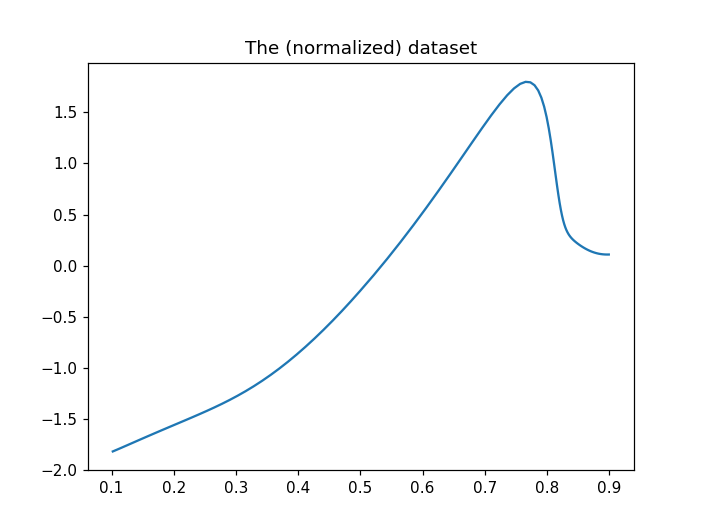

In [2]:
data = np.loadtxt('data-2231875.txt', delimiter=',', skiprows=1)
data[:,1] = preprocessing.scale(data[:,1])
pl.title("The (normalized) dataset")
_ = pl.plot(data[:,0], data[:,1])
#pl.savefig('data.svg')

Next we prepare some set of hypothesis spaces to be tested against each other. Because it's easy and already implemented in the repo, we take two polynomial and two trigonometric families of basis functions.

In [3]:
var = data[:, 1].std()   # Should be approx. 1 after scaling
sigma = 0.1              # Observation noise sigma 
hc = HypothesisCollection()
hc.append(PolynomialHypothesis(M=5, variance=var, noiseVariance=sigma**2))
hc.append(PolynomialHypothesis(M=6, variance=var, noiseVariance=sigma**2))
hc.append(TrigonometricHypothesis(halfM=4, variance=var, noiseVariance=sigma**2))
hc.append(TrigonometricHypothesis(halfM=6, variance=var, noiseVariance=sigma**2))

lr = LinearRegression(hc, sigma)

We now perform bayesian updates to our belief in each hypothesis space. Each data point is fed to the `LinearRegression` object which then performs:
1. Estimation of the weights for each hypothesis.
2. Computation of the posterior probability of each hypothesis, given the data.

In [4]:
%%time
ymin, ymax = min(data[:,1]), max(data[:,1])
# Looping is ugly, but it is what it is! :P
for x, y in data:
    lr.update(x, y)

# MAP values for the weights w_j
wmap = [param.mean for param in lr.parameter]

CPU times: user 203 ms, sys: 4.63 ms, total: 208 ms
Wall time: 213 ms


<IPython.core.display.Javascript object>


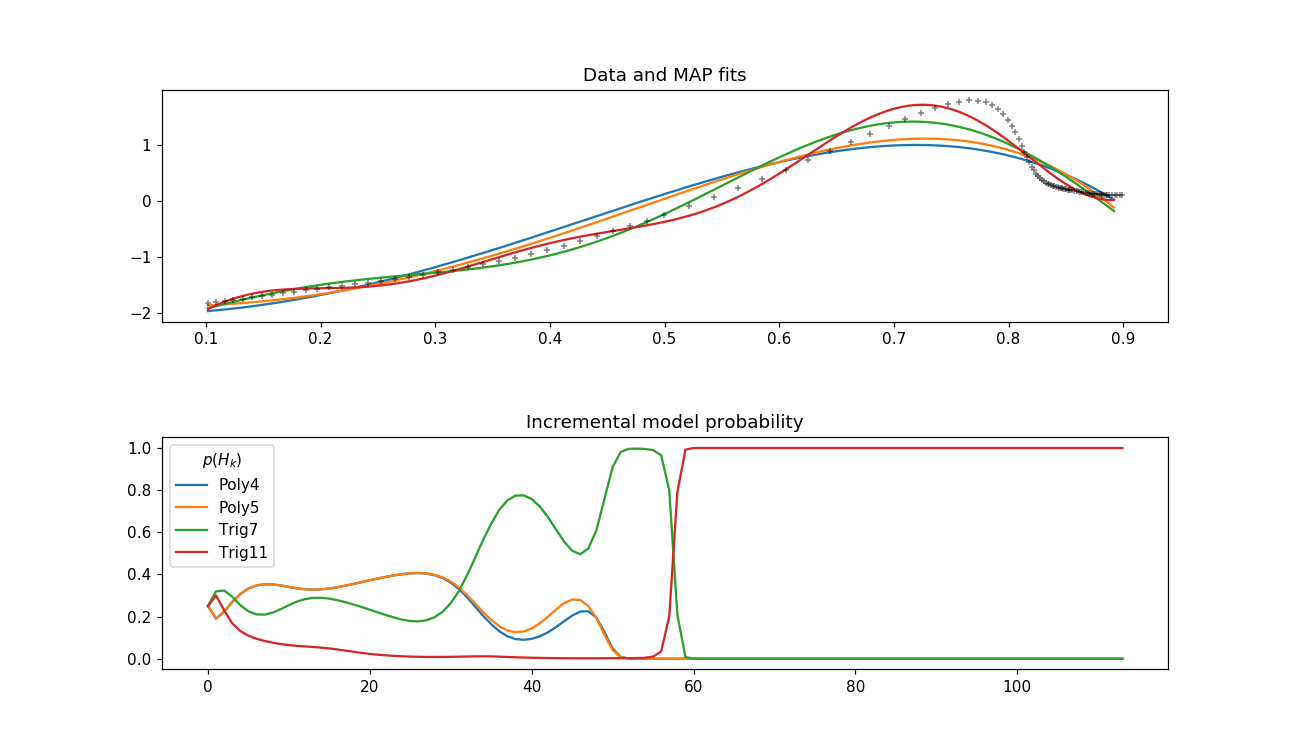

In [5]:
fig, (ax1, ax2) = pl.subplots(2)
updateMAPFitPlot(ax1, lr.XHist, lr.hypotheses, wmap, 0.005) 
ax1.plot(lr.XHist, lr.THist, 'k+', ms=4, alpha=0.5)  # plot the data points
ax1.set_title("Data and MAP fits")
updateProbabilitiesPlot(ax2, lr)
ax2.set_title("Incremental model probability")
fig.subplots_adjust(hspace=0.5)
#pl.savefig('mapfits.svg')
_ = pl.show()

The winner among the hypotheses proposed is clearly the Trigonometric hypothesis  ($H_3$) with $M=12$ basis functions:

$$\phi_j (x) = \cos (\pi j x)\  \text{ for }\ j = 2 k,$$
$$\phi_j (x) = \sin (\pi j x)\  \text{ for }\ j = 2 k+1,$$

where $k \in 0, \ldots, M/2,$. Our best candidate is then

$$f(x) = \sum_{j=0}^11 w_j \phi_j (x). $$

The specific values of the weights $w_j$ are taken from from the _a posteriori_ distribution computed (Gaussian since we started with a Gaussian prior). Their MAP values are:

In [6]:
prob_hypotheses = np.array(lr.probHyp)
winner = np.argmax(prob_hypotheses[:,-1])
wmap[winner].round(2).flatten()

array([ 0.93, -3.17,  1.09, -1.94, -2.07,  1.52,  0.  , -1.14,  0.37,
       -2.63,  3.1 ,  0.37])

Note how the model comparison rejects the hypothesis `Trig7` after seeing about half the dataset and leans in favor of `Trig11` which becomes a better fit. This might come at cost later, though, because `Trig11` is a wildly oscillating polynomial beyond the interval considered whereas `Trig7` is a bit more tame. More data would be needed to decide and besides, you really don't want to extrapolate with your regression ;)

<IPython.core.display.Javascript object>


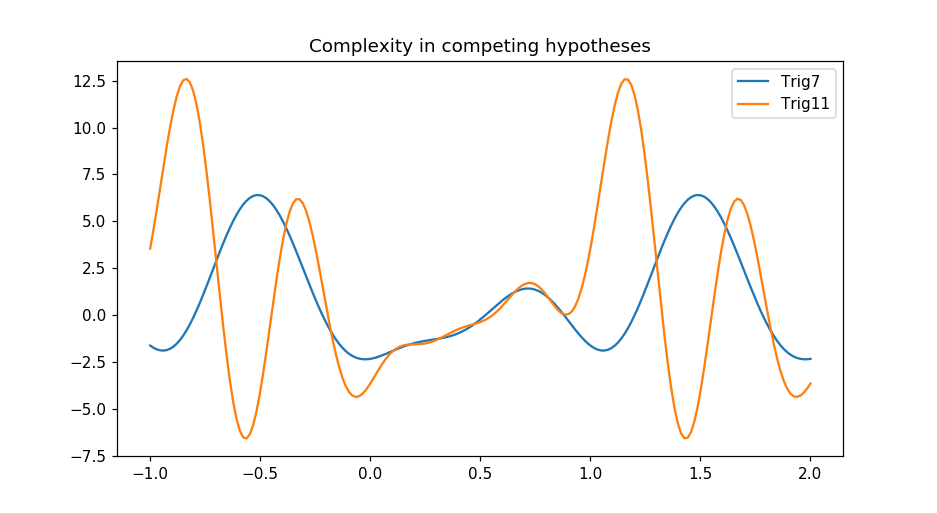

In [7]:
xx = np.linspace(-1,2,200)
for h, w, l in zip(lr.hypotheses[2:], wmap[2:], ['Trig7', 'Trig11']):
    pl.plot(xx, [np.dot(h.evaluate(x).flatten(), w) for x in xx], label=l)
pl.title("Complexity in competing hypotheses")
_ = pl.legend()
#pl.savefig('complexity.svg')

It is important to note that all this doesn't mean that either hypothesis is good (nor that extrapolating beyond the range of the dataset would be wise, no matter how good the fit is), only that one is better than the other. At this point we would need to try more hypothesis spaces, perhaps including functions with compact support at multiple scales and locations. And of course more data.